# ААВ тест в мобильном приложении продуктов питания


Мы работаем в стартапе, который продаёт продукты питания. 
Задачи проекта: 
- разобраться, как ведут себя пользователи нашего мобильного приложения,
- изучить результаты ААВ теста, который был проведен


В нашем распоряжении файл с логами. 
В нем содержится 244126 строк. 

Согласно документации:

Каждая запись в логе — это действие пользователя, или событие.

- EventName — название события;

- DeviceIDHash — уникальный идентификатор пользователя;

- EventTimestamp — время события;

- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

In [ ]:
import pandas as pd
import datetime as dt
import numpy as np
import math as mth
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime
from scipy import stats as st
from plotly import graph_objects as go


## Чтение данных

In [ ]:
 log.sample(10)

,EventName,DeviceIDHash,EventTimestamp,ExpId
131590,OffersScreenAppear,1685496134763216440,1564934562,246
217725,MainScreenAppear,2956083095170517025,1565160487,246
94030,PaymentScreenSuccessful,7124807051950926466,1564840646,248
193938,MainScreenAppear,2034413732318922811,1565095371,247
120304,MainScreenAppear,1864330314524351514,1564916803,246
64109,MainScreenAppear,5025956312643488924,1564760905,247
211107,CartScreenAppear,8309980273750324949,1565121526,246
101155,CartScreenAppear,2910761286178294850,1564851533,248
200405,MainScreenAppear,4287497219556938805,1565104776,247
205552,MainScreenAppear,7731824283088463812,1565111901,247


## Подготовка данных

Изучим общую информацию о данных в файле

In [ ]:
log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Пропусков в данных нет

Согласно документации:

Каждая запись в логе — это действие пользователя, или событие.

EventName — название события;

DeviceIDHash — уникальный идентификатор пользователя;

EventTimestamp — время события;

ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

Изменим названия столбцов на удобные нам

In [ ]:
log.rename(columns={'EventName': 'event', 'DeviceIDHash': 'id', 'EventTimestamp': 'timestamp', 'ExpId': 'group'}, inplace=True)


Добавим столбец с датой и временем. Переведем формат timestamp в datetime.

In [ ]:
log['date_time'] = pd.to_datetime(log['timestamp'], unit = 's')

In [ ]:
 log.sample(10)

,event,id,timestamp,group,date_time
15751,PaymentScreenSuccessful,3528217211962170139,1564658003,247,2019-08-01 11:13:23
152709,OffersScreenAppear,8929264187278182833,1565001124,246,2019-08-05 10:32:04
53194,MainScreenAppear,7519390359963934783,1564743718,248,2019-08-02 11:01:58
47179,MainScreenAppear,7586949343857555269,1564733313,246,2019-08-02 08:08:33
40695,PaymentScreenSuccessful,6304868067479728361,1564713198,248,2019-08-02 02:33:18
17890,MainScreenAppear,587703240071607491,1564660977,246,2019-08-01 12:02:57
33859,OffersScreenAppear,8429505541319539763,1564683996,246,2019-08-01 18:26:36
41627,PaymentScreenSuccessful,4374194959911938890,1564716192,248,2019-08-02 03:23:12
21724,OffersScreenAppear,8070558855125722674,1564666701,246,2019-08-01 13:38:21
132295,PaymentScreenSuccessful,6876075934773831748,1564935772,246,2019-08-04 16:22:52


Добавим столбец с датой без времени

In [ ]:
log['date'] = log['date_time'].dt.date

In [ ]:
 log.sample(10)

,event,id,timestamp,group,date_time,date
215761,MainScreenAppear,1413091616777106146,1565154943,247,2019-08-07 05:15:43,2019-08-07
197803,MainScreenAppear,6857413145640053090,1565101018,248,2019-08-06 14:16:58,2019-08-06
92624,MainScreenAppear,5027370568248751464,1564838295,246,2019-08-03 13:18:15,2019-08-03
214634,CartScreenAppear,1754140665440434215,1565151222,247,2019-08-07 04:13:42,2019-08-07
92765,OffersScreenAppear,8023623688519544332,1564838512,248,2019-08-03 13:21:52,2019-08-03
43145,CartScreenAppear,9110608674894233944,1564723097,246,2019-08-02 05:18:17,2019-08-02
103848,OffersScreenAppear,6377011691662227294,1564856628,246,2019-08-03 18:23:48,2019-08-03
105588,MainScreenAppear,5211717548134904196,1564860184,247,2019-08-03 19:23:04,2019-08-03
238917,MainScreenAppear,7358857170038129131,1565198768,248,2019-08-07 17:26:08,2019-08-07
104543,PaymentScreenSuccessful,674541835027541643,1564858073,248,2019-08-03 18:47:53,2019-08-03


Проверим есть ли дубликаты 

In [ ]:
log.duplicated().sum()

413

413 полных дубликата, т.к. у нас время события указано до секунды, то это действительно дубликаты, а не повторные события примерно в тоже время. Удалим их.

In [ ]:
log = log.drop_duplicates()

In [ ]:
log.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   event      243713 non-null  object        
 1   id         243713 non-null  int64         
 2   timestamp  243713 non-null  int64         
 3   group      243713 non-null  int64         
 4   date_time  243713 non-null  datetime64[ns]
 5   date       243713 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 13.0+ MB


Вывод по разделу: 

Мы прочитали данные, изменили формат столбца с датой, переименовали столбцы и удалили дубликаты

## Изучение и проверка данных

### Сколько всего событий в логе

In [ ]:
log['event'].count()

243713

У нас в таблице осталось 24713 событий.

### Сколько всего пользователей в логе?

In [ ]:
log['id'].nunique()

7551

В логе сведения о 7551 уникальных пользователях

### Сколько в среднем событий приходится на пользователя?

Посмотрим на распределение количества событий

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb8c67db510>]],
      dtype=object)

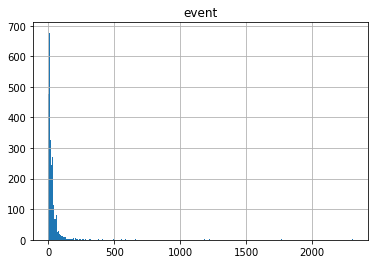

In [ ]:
log.groupby('id').agg({'event':'count'}).hist(bins=1000)

Мы видим, что есть пользователи, которые совершают очень много действий, более 600. Отбрасывать их не стоит, т.к. мы не знаем возможно ли такое взаимодействие с нашим магазином (скорее всего возможно, какие-то постоянные покупатели, которые за 7 дней купили 700 товаров). Поэтому среднее будет сдвигаться в большую сторону и не отобразит реальной картины, лучше использовать медиану.

In [ ]:
log.groupby('id').agg({'event':'count'}).mean()

event    32.275593
dtype: float64

In [ ]:
log.groupby('id').agg({'event':'count'}).median()

event    20.0
dtype: float64

В среднем на одного пользователя приходится 32 события, а медиана на уровне 20 событий на пользователя. 

### Данными за какой период мы располагаем?

In [ ]:
log['date_time'].max()

Timestamp('2019-08-07 21:15:17')

In [ ]:
log['date_time'].min()

Timestamp('2019-07-25 04:43:36')

У нас есть данные с 25 июля 2019 года по 7 августа 20019

Построим гистограмму по дате и времени. 

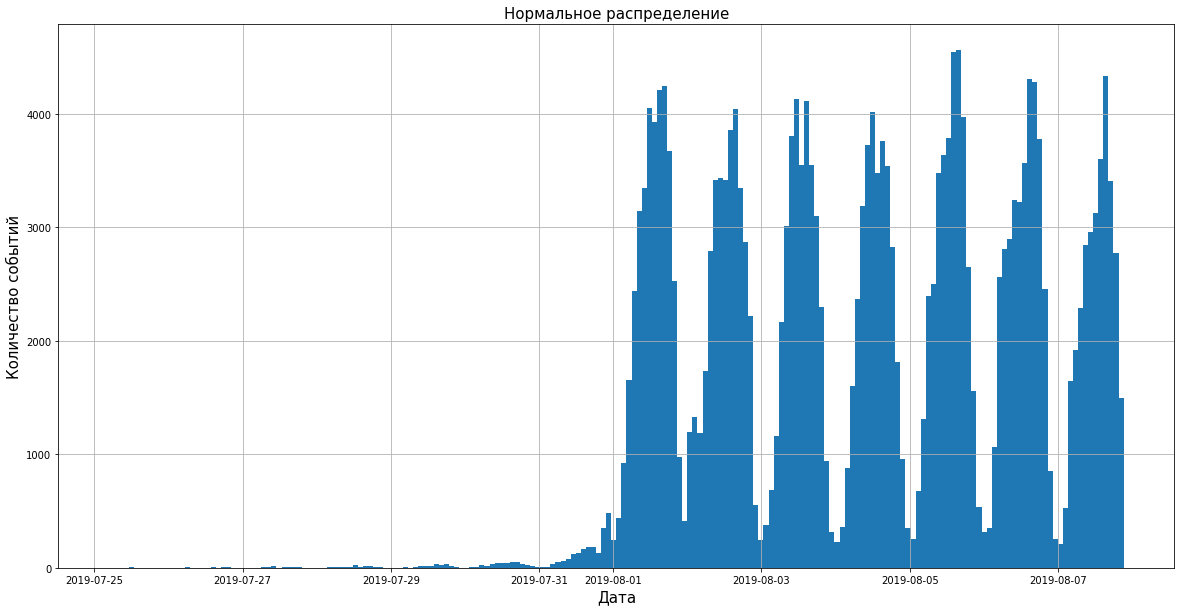

In [ ]:
fig = plt.figure(figsize = (20,10))
ax = log['date_time'].hist(bins=200)

plt.xlabel('Дата', fontsize = 15)
plt.ylabel('Количество событий', fontsize = 15)
plt.title('Нормальное распределение', fontsize = 15)
plt.show()

Мы видим на графике, что большая часть событий была совершена с 1 августа. Полные данные у нас с 1 августа, до этого момента их очень мало и можно отбросить. Возможно раньше были совершены какие-то действия клиентами, которые  войдут в полные данные, например кто-то смотрел главную страницу до 1.08, а купил уже после. Но с другой стороны у нас данные есть ровно по конец дня 7.08. и также будут клиенты, которые сделали 1-2 действия, но совершили покупку позже, так что перекоса думаю не будет.

In [ ]:
log_filter = log.query('datetime(2019, 8, 1).date() <= date <= datetime(2019, 8, 7).date()')

Получается полные данные у нас есть за 1 неделю, с 1.08. по 07.08.2019

### Много ли событий и пользователей вы потеряли, отбросив старые данные?

In [ ]:
log['id'].nunique()-log_filter['id'].nunique()

17

In [ ]:
log['event'].count()-log_filter['event'].count()

2826

Мы потеряли 17 пользователей и 2826 событий. 

Рассчитаем сколько это в процентах от общего числа

In [ ]:
round(((log['id'].nunique()-log_filter['id'].nunique())/log['id'].nunique() * 100),2)

0.23

In [ ]:
round(((log['event'].count()-log_filter['event'].count())/log['event'].count() * 100),2)

1.16

Это около 1% событий и 0,23% пользователей. Доли получились очень маленькие, решение отбросить их не повлияет на результаты исследования

### Проверим, что у нас есть пользователи из всех трёх экспериментальных групп.

In [ ]:
log_filter.groupby('group').agg({'event':'count'})

,event
group,
246,79302
247,77022
248,84563


У нас есть пользователи из всех трех групп

Проверим, есть ли пользователи, которые попали сразу в 2 или более группы

In [ ]:
log_filter.groupby('id').agg({'group':'nunique'}).query('group>1').shape[0]

0

Таких пользователей нет. Все пользователи находятся только в одной группе

*Вывод по разделу:*

Мы изучили данные выяснили:

- в таблице  24713 событий и 7551 уникальных пользователей

- в среднем (по медиане) 20 событий на пользователя

- полные данные у нас есть за 1 неделю, с 1.08. по 07.08.2019

- из-за первоначальных не полных данных мы отбросили 1% событий и 0,23% пользователей

- у нас есть пользователи из всех 3 групп и они не пересекаются

## Изучим воронку событий

Посмотрим, какие события есть в логах, как часто они встречаются. 

In [ ]:
event_g = log_filter.groupby('event').agg({'date':'count'}).sort_values(by = 'date', ascending = False).reset_index()
event_g.columns = ['event', 'count']
event_g

,event,count
0,MainScreenAppear,117328
1,OffersScreenAppear,46333
2,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей.

In [ ]:
id_e = log_filter.groupby('event').agg({'id':'nunique'}).sort_values(by = 'id', ascending = False).reset_index()
id_e.columns = ['event', 'id']
id_e

,event,id
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


 Посчитайте долю пользователей, которые хоть раз совершали событие.

In [ ]:
id_e['ratio'] = round((id_e['id']/log_filter['id'].nunique()),2)

In [ ]:
id_e

,event,id,ratio
0,MainScreenAppear,7419,0.98
1,OffersScreenAppear,4593,0.61
2,CartScreenAppear,3734,0.50
3,PaymentScreenSuccessful,3539,0.47
4,Tutorial,840,0.11


Мы видим 5 видов событий в логе.

Больше всего MainScreenAppear - видимо это просмотры главной страницы, 

затем OffersScreenAppear - просмотры товаров,

CartScreenAppear - добавление товаров в корзину, 

PaymentScreenSuccessful - успешный платеж, 

Tutorial - обращение к инструкции

Все события, кроме просмотра инструкции выстраиваются в логическую цепочку. Клиент заходит на главную страницу, просматривает товары, добавляет их в корзину и оплачивает выбранные товары. Инструкцию(руководство) клиент может смотреть на любом шаге и это не обязательное действие. Правильно будет убрать Tutorial из воронки

In [ ]:
id_f = id_e[0:4]
id_f

,event,id,ratio
0,MainScreenAppear,7419,0.98
1,OffersScreenAppear,4593,0.61
2,CartScreenAppear,3734,0.50
3,PaymentScreenSuccessful,3539,0.47


Построим график воронки

In [ ]:
fig = go.Figure(
    go.Funnel(
        y=[
            'Посетителей главной страницы',
            'Посмотрели товар',
            'Добавили товар в корзину',
            'Оплатили'
        ],
        x=id_f['id'],
         textinfo = "value+percent initial+percent previous"
    )
)
fig.show() 

*Вывод по разделу:*

По воронке мы видим, что от общего числа посетителей главной страницы, перешли на следующий шаг - просмотр товара - 62%, добавили товар в корзину 50% от общего числа посетителей и 81% от пользователей прошедших предыдущий шаг, оплатили товар - 48% от общего числа посетителей и 95% от пользователей прошедших предыдущий шаг.

Получается, что больше всего пользователей теряется между шагом 1 и 2: просмотром главной страницы и просмотром товаров, потеряли 38% посетителей. 

До шага оплаты дошли 48% от первоначального числа посетителей.

## Изучим результаты эксперимента

Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясним, какой шрифт лучше.

### Посчитаем сколько пользователей в каждой экспериментальной группе

In [ ]:
users = log_filter.groupby('group').agg({'id':'nunique'}).reset_index()
users



,group,id
0,246,2484
1,247,2513
2,248,2537


Во всех группах около 2500 пользователей. 

In [ ]:
us_246 = users.loc[0,'id']
us_247 = users.loc[1,'id']
us_248 = users.loc[2,'id']



Рассчитаем на сколько в процентах отличаются группы

In [ ]:
 # разница групп 246 и 247
 round(((1-(us_246/us_247))*100), 2)

1.15

In [ ]:
 # разница групп 246 и 248
 round(((1-(us_246/us_248))*100), 2)

2.09

Количество уникальных пользователей в группах различается на 1,15% в группах А и на 2,09% с группой B

### Рассмотрим сколько пользователей из каждой группы приходится на каждое событие

In [ ]:
users_by_events = log_filter.pivot_table(index = 'event',
                                   columns = 'group',
                                   values = 'id',
                                   aggfunc = 'nunique').reset_index()
users_by_events.columns = ['event', '246', '247', '248']
users_by_events

,event,246,247,248
0,CartScreenAppear,1266,1238,1230
1,MainScreenAppear,2450,2476,2493
2,OffersScreenAppear,1542,1520,1531
3,PaymentScreenSuccessful,1200,1158,1181
4,Tutorial,278,283,279


### Проверим, находят ли статистические критерии разницу между выборками 246 и 247.

 Cравним доли клиентов, совершивших события, используем z-тест.

Напишем функцию которая будет расчитывать p-value 

In [ ]:
def ztest(successes_1, successes_2, trials_1, trials_2):
  
  successes = np.array([successes_1, successes_2])
  trials = np.array([trials_1, trials_2])
  
  # пропорция успехов в первой группе:
  p1 = successes[0]/trials[0]

  # пропорция успехов во второй группе:
  p2 = successes[1]/trials[1]

  # пропорция успехов в комбинированном датасете:
  p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

  # разница пропорций в датасетах
  difference = p1 - p2 

  # считаем статистику в ст.отклонениях стандартного нормального распределения
  z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

  # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
  distr = st.norm(0, 1)  

  p_value = (1 - distr.cdf(abs(z_value))) * 2

  return p_value

  

И функцию, которая будет выводить результаты теста

In [ ]:
 def print_result (p_value):

   alpha = 0.05 # критический уровень статистической значимости

   print('p-значение: ', p_value)

   if p_value < alpha:
     print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
   else:
     print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 


Проверим результаты А/А теста по самому популярному событию MainScreenAppear

Сформулируем нулевую гипотезу: между долями клиентов из групп 246 и  247, посетитившими главную страницы, нет статистической разницы.

In [ ]:
print_result(ztest(users_by_events.loc[1,'246'], users_by_events.loc[1,'247'], us_246, us_247))

p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверим используя эту же функцию и остальные события.

Сформулируем нулевую гипотезу: между долями клиентов из групп 246 и 247, посетитившими страницы товара, нет статистической разницы.

In [ ]:
print_result(ztest(users_by_events.loc[2,'246'], users_by_events.loc[2,'247'], us_246, us_247))

p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Сформулируем нулевую гипотезу: между долями клиентов из групп 246 и 247, положившими товар в корзину, нет статистической разницы.

In [ ]:
print_result(ztest(users_by_events.loc[0,'246'], users_by_events.loc[0,'247'], us_246, us_247))

p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Сформулируем нулевую гипотезу: между долями клиентов из групп 246 и 247, оплатившими товар, нет статистической разницы.

In [ ]:
print_result(ztest(users_by_events.loc[3,'246'], users_by_events.loc[3,'247'], us_246, us_247))

p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Все нулевые гипотезы о равенстве долей контрольных групп по разным событиям не удалось опровергнуть.

 Следовательно тест проведен корректно - статзначимых различий между двумя А-группами не обнаружено.

## Изучим результаты АВ-теста

### Проверим результаты А/В теста между группами 246 и 248

Проверим результаты А/В теста между группами 246 и 248 по самому популярному событию MainScreenAppear

Сформулируем нулевую гипотезу: между долями клиентов из групп 246 и  248, посетитившими главную страницы, нет статистической разницы.

In [ ]:
print_result(ztest(users_by_events.loc[1,'246'], users_by_events.loc[1,'248'], us_246, us_248))

p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверим используя эту же функцию и остальные события.

Сформулируем нулевую гипотезу: между долями клиентов из групп 246 и 248, посетитившими страницы товара, нет статистической разницы.


In [ ]:
print_result(ztest(users_by_events.loc[2,'246'], users_by_events.loc[2,'248'], us_246, us_248))

p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Сформулируем нулевую гипотезу: между долями клиентов из групп 246 и 248, положившими товар в корзину, нет статистической разницы.

In [ ]:
print_result(ztest(users_by_events.loc[0,'246'], users_by_events.loc[0,'248'], us_246, us_248))

p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Сформулируем нулевую гипотезу: между долями клиентов из групп 246 и 248, оплатившими товар, нет статистической разницы.

In [ ]:
print_result(ztest(users_by_events.loc[3,'246'], users_by_events.loc[3,'248'], us_246, us_248))

p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


*Вывод:*

Нет статистически значимого различия по прохождению по событиям воронки между клиентами групп 246 и 248. Измение шрифта не принесло результата

### Проверим результаты А/В теста между группами 247 и 248

Проверим результаты А/В теста между группами 247 и 248 по самому популярному событию MainScreenAppear

Сформулируем нулевую гипотезу: между долями клиентов из групп 247 и  248, посетитившими главную страницы, нет статистической разницы.

In [ ]:
print_result(ztest(users_by_events.loc[1,'247'], users_by_events.loc[1,'248'], us_247, us_248))

p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверим используя эту же функцию и остальные события.

Сформулируем нулевую гипотезу: между долями клиентов из групп 247 и 248, посетитившими страницы товара, нет статистической разницы.


In [ ]:
print_result(ztest(users_by_events.loc[2,'247'], users_by_events.loc[2,'248'], us_247, us_248))

p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Сформулируем нулевую гипотезу: между долями клиентов из групп 247 и 248, положившими товар в корзину, нет статистической разницы.

In [ ]:
print_result(ztest(users_by_events.loc[0,'247'], users_by_events.loc[0,'248'], us_247, us_248))

p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Сформулируем нулевую гипотезу: между долями клиентов из групп 247 и 248, оплатившими товар, нет статистической разницы.

In [ ]:
print_result(ztest(users_by_events.loc[3,'247'], users_by_events.loc[3,'248'], us_247, us_248))

p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


### Проверим результаты А/В теста между объединённой контрольной группой и 248

Объединим данные 246 и 247 группы

In [ ]:
users_by_events['246_247'] = users_by_events['246'] + users_by_events['247']

In [ ]:
users_by_events

,event,246,247,248,246_247
0,CartScreenAppear,1266,1238,1230,2504
1,MainScreenAppear,2450,2476,2493,4926
2,OffersScreenAppear,1542,1520,1531,3062
3,PaymentScreenSuccessful,1200,1158,1181,2358
4,Tutorial,278,283,279,561


Проверим результаты А/В теста между между объединённой контрольной группой и 248 по самому популярному событию MainScreenAppear

Сформулируем нулевую гипотезу: между долями клиентов из объединённой контрольной группы и 248, посетитившими главную страницы, нет статистической разницы.


In [ ]:
print_result(ztest(users_by_events.loc[1,'246_247'], users_by_events.loc[1,'248'], us_247+us_246, us_248))

p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверим используя эту же функцию и остальные события.

Сформулируем нулевую гипотезу: между долями клиентов из объединённой контрольной группы и 248, посетитившими страницы товара, нет статистической разницы.

In [ ]:
print_result(ztest(users_by_events.loc[2,'246_247'], users_by_events.loc[2,'248'], us_247+us_246, us_248))


p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Сформулируем нулевую гипотезу: между долями клиентов из объединённой контрольной группы и 248, положившими товар в корзину, нет статистической разницы.

In [ ]:
print_result(ztest(users_by_events.loc[0,'246_247'], users_by_events.loc[0,'248'], us_247+us_246, us_248))

p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Сформулируем нулевую гипотезу: между долями клиентов из объединённой контрольной группs и 248,  оплатившими товар, нет статистической разницы.

In [ ]:
print_result(ztest(users_by_events.loc[3,'246_247'], users_by_events.loc[3,'248'], us_247+us_246, us_248))

p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


В итоге при проверке результатов А/В теста мы провели 16 проверок гипотез. В этом случае увеличивается вероятность ложноположительного результата эксперимента. Для снижения такой вероятности применяются разные методы, самый простой (при этом достаточно грубый) поправка Бонферрони. При этом alpha делится на количество экспериментов. В нашем случае их 16, т.е. alpha = 0.05/16 = 0,003. Но ни одно из значений p-value, которые мы получили не меньше 0,05. Соответственно при применении поправки Бонферрони мы получим те же результаты

*Вывод по разделу:*

При проведении эксперимента не выявлено статистически значимой разницы между группами А, А и В. Шрифт не повлиял на поведение пользователей. 

## Общий вывод по проекту:

Мы проанализировали лог с данными интернет магазина. 

Мы прочитали данные, изменили формат столбца с датой, переименовали столбцы и удалили дубликаты

Построили воронку событий, выявили, что от общего числа посетителей главной страницы, перешли на следующий шаг - просмотр товара - 62%, добавили товар в корзину 50% от общего числа посетителей и 81% от пользователей прошедших предыдущий шаг, оплатили товар - 48% от общего числа посетителей и 95% от пользователей прошедших предыдущий шаг.

Получается, что больше всего пользователей теряется между шагом 1 и 2: просмотром главной страницы и просмотром товаров, потеряли 38% посетителей. 

При анализе ААВ теста не выявлено статистически значимой разницы между поведением клиентов из групп А, А и В. Шрифт не повлиял на поведение пользователей. Можно оставить любой шрифт из 2-х. 

